Combine the results of notebooks:

"27. psf measurement evaluation - part 2"<br>
"27. psf measurement evaluation - part 3"<br>
"28. algorithm shootout - updated"<br>

We will generate images with increasing densities, fit their PSFs, and then evaluate A&L and ZOGY on those images.

Note that we will use the fitted PSFs from images at varying densities, but will then evaluate the algorithms on images with constant density (1,000 stars) to remove the false-negative effect of increasing stellar density from the mix.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


In [2]:
import diffimTests as dit
reload(dit)

<module 'diffimTests' from 'diffimTests.pyc'>

In [3]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

In [10]:
sky = 300.

def runTest(n_sources=500, seed=66, n_varSources=50, flux=1500., scintillation=0., printErrs=False):
    out = None
    try:
        # Make the "varying density" object to fit PSFs on
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        # Make the "constant density" object to actually run the tests on
        testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=1000, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        if scintillation == 0:
            testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.
            testObj2.astrometricOffsets[0] = testObj2.astrometricOffsets[1] = 0.

        try:
            testRes1 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE1', e
            testRes1 = None
        
        try:
            actualPsf1 = testObj.im1.psf.copy() #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            im1 = testObj.im1.asAfwExposure()
            res1 = dit.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = dit.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            normedRms1 = computeNormedPsfRms(psf1a, actualPsf1)
            sh = dit.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = dit.computeMoments(psf1)
        except Exception as e:
            if printErrs:
                print 'HERE2', e
            psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None

        try:
            actualPsf2 = testObj.im2.psf.copy() #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            im2 = testObj.im2.asAfwExposure()
            res2 = dit.measurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = dit.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            normedRms2 = computeNormedPsfRms(psf2a, actualPsf2)
            sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = dit.computeMoments(psf2)
        except Exception as e:
            if printErrs:
                print 'HERE3', e
            psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None

        try:
            testObj2.reset()
            psf1b = psf1a.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()
            psf2b = psf2a.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()
            testObj2.im1.psf = psf1b
            testObj2.im2.psf = psf2b
            testRes2 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE4', e
            testRes2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed,
               'diffimResInputPsf': testRes1, 'diffimResMeasuredPsf': testRes2,
               'normedRms1': normedRms1, 'normedRms2': normedRms2}
    except Exception as e:
        if printErrs:
            print 'HERE5', e
        pass
    return out

In [11]:
tmp = runTest(n_sources=50, seed=1, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

HERE2 No objects passed our cuts for consideration as psf stars
HERE3 No objects passed our cuts for consideration as psf stars
HERE4 local variable 'psf1a' referenced before assignment


{'diffimResInputPsf': {'ALstack': {'FN': 25, 'FP': 4, 'TP': 25},
  'ALstack_noDecorr': {'FN': 21, 'FP': 3, 'TP': 29},
  'SZOGY': {'FN': 13, 'FP': 5, 'TP': 37},
  'ZOGY': {'FN': 11, 'FP': 3, 'TP': 39}},
 'diffimResMeasuredPsf': None,
 'inputShape1': None,
 'inputShape2': None,
 'moments1': None,
 'moments2': None,
 'nSources': 50,
 'normedRms1': None,
 'normedRms2': None,
 'rms1': None,
 'rms2': None,
 'seed': 1,
 'shape1': None,
 'shape2': None}

In [12]:
tmp = runTest(n_sources=4500, seed=2, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 17, 'FP': 0, 'TP': 33},
  'ALstack_noDecorr': {'FN': 13, 'FP': 2, 'TP': 37},
  'SZOGY': {'FN': 9, 'FP': 4, 'TP': 41},
  'ZOGY': {'FN': 7, 'FP': 2, 'TP': 43}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 19, 'FP': 0, 'TP': 31},
  'ALstack_noDecorr': {'FN': 12, 'FP': 1, 'TP': 38},
  'SZOGY': {'FN': 49, 'FP': 171, 'TP': 1},
  'ZOGY': {'FN': 49, 'FP': 229, 'TP': 1}},
 'inputShape1': [1.5999732062394578,
  2.5599142606841707,
  2.5599142606841707,
  0.0],
 'inputShape2': [1.989961637274519,
  4.039946238041112,
  4.039946238041112,
  -0.799989278877403],
 'moments1': (20.211269163827467, 19.735380511528515),
 'moments2': (20.101578383507171, 18.898314215063806),
 'nSources': 4500,
 'normedRms1': 0.00814273062556959,
 'normedRms2': 0.032809564121434626,
 'rms1': 0.00037452809165916247,
 'rms2': 0.0011781896117898263,
 'seed': 2,
 'shape1': [1.606901416031468,
  2.5791441256859735,
  2.5852876620761984,
  0.020566739840629247],
 'shape2': [2.1036486918

In [13]:
#inputs = [(i, j) for i in np.insert(np.arange(50, 5000, 100), 0, [5,10,25,35]) for j in np.arange(1, 10)]
inputs = [(i, j) for i in np.insert(np.arange(250, 5250, 500), 0, [5,10,25,35,50,100,150,200]) for j in np.arange(1, 25)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)
import cPickle; import gzip
cPickle.dump(testResults1, gzip.GzipFile('28. algorithm shootout - vs stellar density using measured PSFs.p.gz', 'wb'))

432


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 24.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 130.7min
[Parallel(n_jobs=3)]: Done 432 out of 432 | elapsed: 206.6min finished


432 312


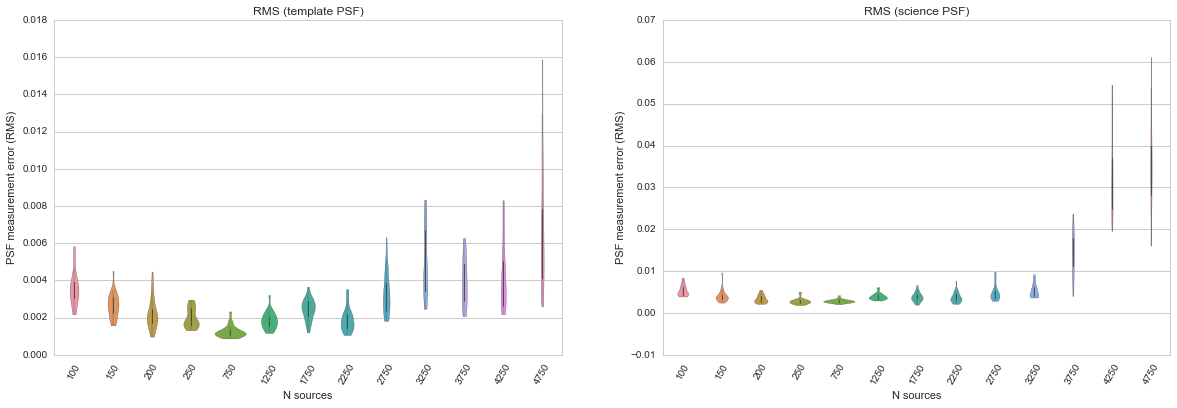

In [14]:
ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults1[i] is not None])
tr = [t for t in testResults1 if t is not None and t['inputPsf1'] is not None and t['psf1'] is not None]
tr = [t for t in tr if t is not None and t['inputPsf2'] is not None and t['psf2'] is not None]
#tr = [t for t in tr if t is not None and t['psf1'] is not None]
#tr = [t for t in tr if t['rms1'] is not None]
#tr = [t for t in tr if t['rms2'] is not None]
print len(testResults1), len(tr)
ns = np.array([t['nSources'] for t in tr if t is not None])
rms1s = [computeNormedPsfRms(t['psf1'], t['inputPsf1']) for t in tr if t is not None]
rms2s = [computeNormedPsfRms(t['psf2'], t['inputPsf2']) for t in tr if t is not None]

tr = {'nSources': ns,
      #'rms1': np.array([t['rms1'] for t in tr])*100.,
      #'rms2': np.array([t['rms2'] for t in tr])*100.,
      #'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
      #'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])
     }
tr = pd.DataFrame(tr)

tr['rms1'] = np.array(rms1s)
tr['rms2'] = np.array(rms2s)

matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

In [19]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    tr = [t for t in tr if t is not None]
    tr = [t for t in tr if t is not None and t['diffimResMeasuredPsf']]
    TP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FP'] for t in tr]) for key in methods})

    TP['nSources'] = np.array([t['nSources'] for t in tr])
    FP['nSources'] = np.array([t['nSources'] for t in tr])
    FN['nSources'] = np.array([t['nSources'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (24.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['nSources', methods[0]]]
    tmp2 = TP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0], scale='width')
    g.set_title('True Positives')
    g.set_ylim((0, 52))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['nSources', methods[0]]]
    tmp2 = FP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], width=1.2, scale='width')
    g.set_title('False Positives')
    g.set_ylim((0, 50))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);
    
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

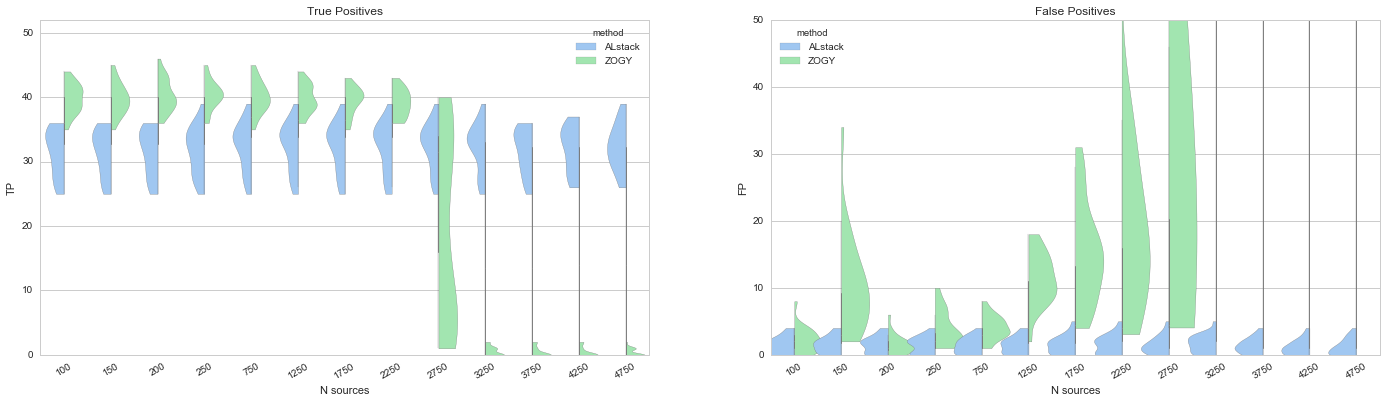

In [20]:
#testResults1 = cPickle.load(gzip.GzipFile('28. algorithm shootout - vs stellar density using measured PSFs.p.gz', 'rb'))
plotResults(testResults1, methods=['ALstack', 'ZOGY'])